# ERSP calculations test on artificial signals

## Table of Contents

* [Import libraries](#import)
* [Initialization](#init)
    * [Ensure that the root directory is the project directory](#directory)
    * [Generate signals](#gen)
        * [Store signals](#storesignals)
        * [Define markers](#markers)
    * [Generate noise](#noise)
        * [Plot noise](#noiseplot)
        * [Add noise to signals](#addnoise)
    * [Signal selector and time plot](#timeplot)
    * [Time and frequency plot (FFT)](#fftplot)
* [2-PSD around markers and ratio calculation: New method](#new)
    * [Compute the PSDs around all markers for one signal](#psdnew)
    * [Select PSD results around selected marker for one signal](#selectpsd)
    * [Plot signal i's PSDs around selected marker](#psdplotnew)
    * [Analysis 1](#analysis1new)
    * [Plot Signal i's ERSP around 1st marker 111](#ERSPnew)
    * [Analysis 2](#analysis2new)



## Import libraries<a name="import"></a>

In [52]:
import os
import pyxdf # xdf file importation
import matplotlib.pyplot as plt
import numpy as np
from my_functions import *
# library for creating filters
from scipy.signal import butter, iirnotch, filtfilt, welch,argrelextrema,convolve
#%matplotlib widget

In [53]:
plt.close("all")  # close all figure windows

## Initialization <a   name="init"></a>

### Ensure that the root directory is the project directory <a   name="directory"></a>
In some cases, the root directory may not be the project directory. This is usually the case when the notebook is run from a subdirectory of the project directory.

In [54]:
# if pwd is SRC  change to root
print("Current working directory: ", os.getcwd())
if os.path.basename(os.getcwd()) == "SRC":
    os.chdir("..")
print("Current working directory: ", os.getcwd())
print(os.path.basename(os.getcwd()))

Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Stage_Signal_Physio


### Generate signals <a   name="gen"></a>

Generation of 3 sinusoidal signals of different frequencies but same duration and sampling frequency.
For both, the amplitude change at mid length (time).

- Signal 1 (F=12Hz) starts with an amplitude of  100 (A.U) and change to 10.
- Signal 2 (F=20Hz) starts with an amplitude of 20(A.U) and change to 10
- Signal 3 is a combination of signal 1 and 3

In [55]:
#Signal generation (2 signals)
Srate=500
length_time=20
change_time=length_time/2

signal_frequency1=12
signal_frequency2=20
signal_frequency3="12 + 20 "

original_amp_1=100
new_amp_1=original_amp_1/10
#new_amp_1=original_amp_1

original_amp_2=20
new_amp_2=original_amp_2/2


times,signal_amplitudes1=generate_sine_wave(amplitude=original_amp_1, frequency=signal_frequency1, duration=length_time, 
                               change_time=change_time, new_amplitude=new_amp_1, sample_rate=Srate)
times2,signal_amplitudes2=generate_sine_wave(amplitude=original_amp_2, frequency=signal_frequency2, duration=length_time, 
                               change_time=change_time, new_amplitude=new_amp_2, sample_rate=Srate)

signal_mixed_amplitudes=signal_amplitudes1+signal_amplitudes2

#### Store signals <a   name="storesignals"></a>

In [56]:
#stacking the signals as columns of a single 2D array (to be able to use the nearest_timestamps_array_finder and compute_lagged_psd2_all_electrodes functions)
signal_electrodes=np.column_stack((signal_amplitudes1,signal_amplitudes2,signal_mixed_amplitudes)) 
print(signal_electrodes.shape)

(10000, 3)


#### Define markers <a   name="markers"></a>

Creation of an array of markers and their timestamps as  list of tuples (timestamp,"marker_name") representing the onset of an event.
- This will serve as reference to PSD calculations.
- Here only the marker (111) corresponds to an event (amplitude change) at mid-duration.


In [57]:
#create table of event markers and their timestamps
#marker_timestamps=np.array([(change_time-3,100),(change_time,111),(change_time+3,100),(change_time+6,111)])
marker_timestamps=np.array([(change_time-5,100),(change_time,111),(change_time+5,100)])

### Generate noise <a   name="noise"></a>

In [58]:
#Generate noise
noise=np.random.uniform(low=-3,high=3,size=(len(signal_amplitudes1),1))
print(np.shape(noise))
noise_fftfreqs,noise_fft_magnitudes=fft_compute_on_single_channel2(signal=noise,Fs=Srate)

(10000, 1)


#### Plot noise <a   name="noiseplot"></a>

Text(0.5, 0.98, 'Noise signal: Time plot and FFT')

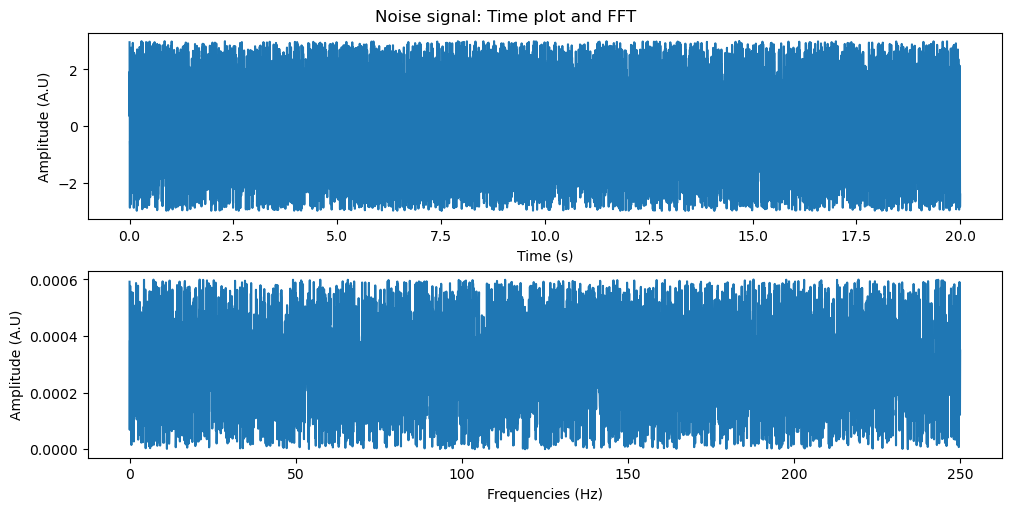

In [59]:
figure,axis=plt.subplots(2,num=1,figsize=(10,5),layout="constrained")
axis[0].plot(times,noise)
axis[0].set_ylabel("Amplitude (A.U)")
axis[0].set_xlabel("Time (s)")

axis[1].plot(noise_fftfreqs,noise_fft_magnitudes)
axis[1].set_ylabel("Amplitude (A.U)")
axis[1].set_xlabel("Frequencies (Hz)")
figure.suptitle("Noise signal: Time plot and FFT")

#### Add noise to signals <a   name="addnoise"></a>

In [60]:
#Add noise to signals
noise_button=True
if noise_button is True:
    signal_electrodes=signal_electrodes+noise

### Signal selector and time plot <a   name="timeplot"></a>

In [61]:
#select the signal [1,3]
ELECTRODE_NUM=3
SELECTOR=ELECTRODE_NUM-1 #Due to python indices

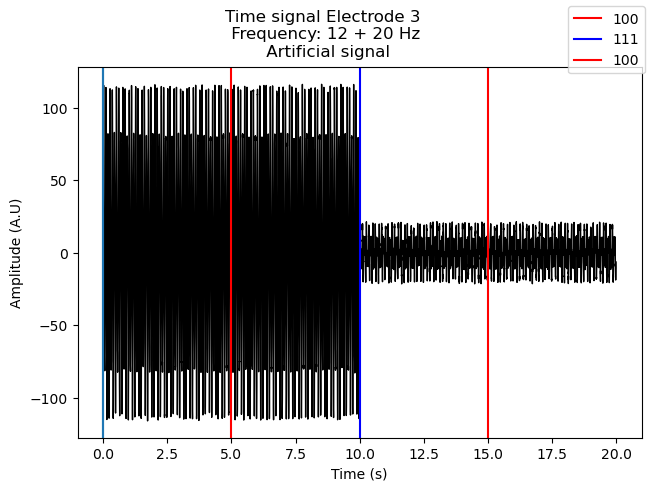

In [62]:
#Plot time signal i and the event markers
single_plot(filename="Artificial signal",fig_number=2,x=times,y=signal_electrodes[:,SELECTOR],markers_times_array=marker_timestamps,
            fig_title=f"Time signal Electrode {ELECTRODE_NUM} \n Frequency: {eval('signal_frequency'+str(ELECTRODE_NUM))}Hz",
            xlabel="Time (s)",ylabel="Amplitude (A.U)")


### Time and frequency plot (FFT) <a   name="fftplot"></a>

In [63]:
FFT_whole_signals=compute_fft_on_all_channels2(channels_signals=signal_electrodes,Fs=Srate)
FFT_first_half_signals=compute_fft_on_all_channels2(channels_signals=signal_electrodes[0:(len(signal_electrodes)//2)+1],Fs=Srate)
FFT_second_half_signals=compute_fft_on_all_channels2(channels_signals=signal_electrodes[(len(signal_electrodes)//2):],Fs=Srate)

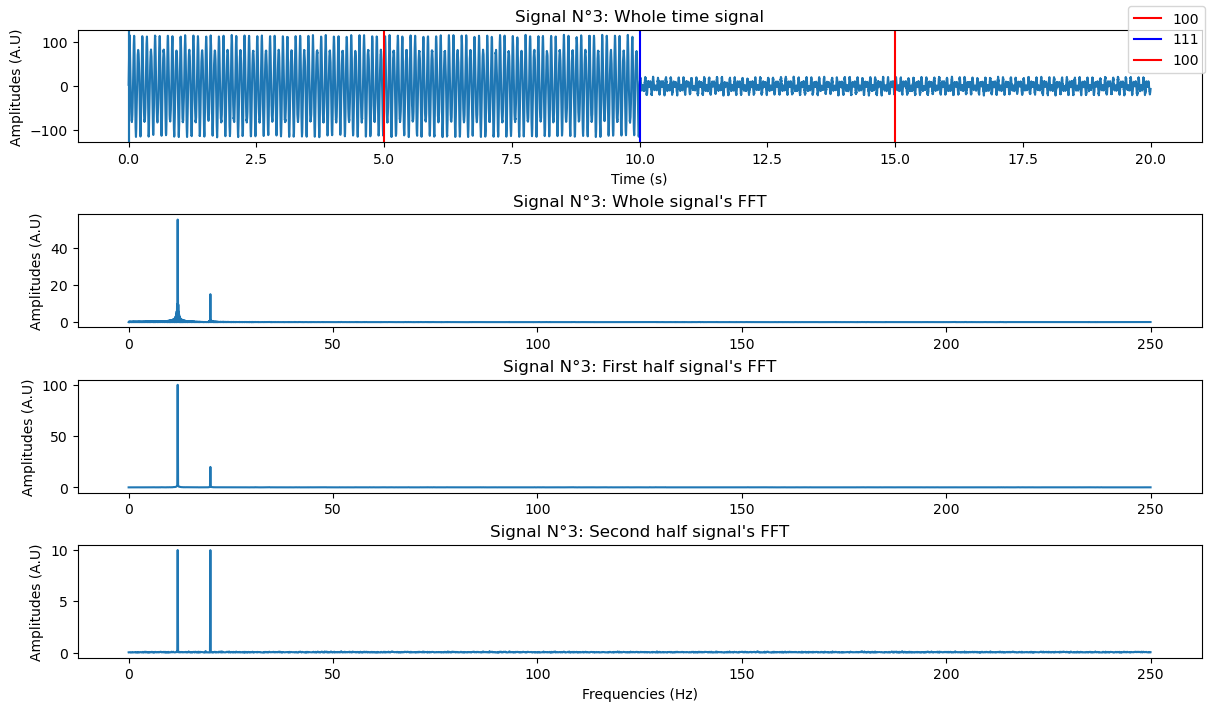

In [64]:
figure,axis=plt.subplots(4,num=3,figsize=(12,7),layout="constrained")
axis[0].set_title("Signal N°"+str(ELECTRODE_NUM)+": Whole time signal")
axis[0].plot(times,signal_electrodes[:,SELECTOR])
axis[0].set_ylabel("Amplitudes (A.U)")
axis[0].set_xlabel("Time (s)")
show_markers(axis[0], marker_timestamps)

axis[1].set_title("Signal N°"+str(ELECTRODE_NUM)+": Whole signal's FFT")
axis[1].plot(FFT_whole_signals["FFT_frequencies"][:,SELECTOR],FFT_whole_signals["FFT_magnitudes"][:,SELECTOR])
axis[1].set_ylabel("Amplitudes (A.U)")

axis[2].set_title("Signal N°"+str(ELECTRODE_NUM)+": First half signal's FFT")
axis[2].plot(FFT_first_half_signals["FFT_frequencies"][:,SELECTOR],FFT_first_half_signals["FFT_magnitudes"][:,SELECTOR])
axis[2].set_ylabel("Amplitudes (A.U)")

axis[3].set_title("Signal N°"+str(ELECTRODE_NUM)+": Second half signal's FFT")
axis[3].plot(FFT_second_half_signals["FFT_frequencies"][:,SELECTOR],FFT_second_half_signals["FFT_magnitudes"][:,SELECTOR])
axis[3].set_ylabel("Amplitudes (A.U)")
axis[3].set_xlabel("Frequencies (Hz)")
figure.legend()

## 2-PSD around markers and ratio calculation: New method<a   name="new"></a>

### Compute the PSDs around all markers for one signal<a   name="psdnew"></a>

In [65]:
# Segment length of the signal on which the PSD is computed (expressed in seconds)
TIME_WINDOW=4  #in seconds

In [66]:
#Find the nearest signal timepoint for each marker (timestamps,markers) (in case a marker is between two samples)
#returns a dictionary of arrays ("markers_timestamp_indices","markers_timestamps", "marker_labels")
nearest_markers= nearest_timestamps_array_finder(
    times, marker_timestamps) 

MARKERS LEN: 3


In [67]:
#Compute the power spectrum on segments before and after all markers for selected electrode

#freqs, Pxx_density=compute_welch_estimation_on_segment2(segment=signal_electrodes[:,SELECTOR],sample_rate=Srate,nfft=len(signal_electrodes[:,SELECTOR])) #over whole signal

before=compute_welch_on_a_signal_before_each_marker(signal_electrodes[:,SELECTOR], sample_rate=Srate, 
                                                  markers_array=nearest_markers, segment_duration=TIME_WINDOW) #over TIME_WINDOW sec before each marker

after=compute_welch_on_a_signal_after_each_marker(signal_electrodes[:,SELECTOR], sample_rate=Srate,  #over PSD_WINDOW sec after each marker
                                                  markers_array=nearest_markers, segment_duration=TIME_WINDOW)
baselines=compute_welch_on_a_signal_before_each_marker(signal_electrodes[:,SELECTOR], sample_rate=Srate,  #over 1sec after each
                                                  markers_array=nearest_markers, segment_duration=1)

print("before shape",len(before))
print("after shape",len(after))

nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
before shape 2
after shape 2


### Select PSD results around selected marker for one signal<a   name="selectpsd"></a>

In [68]:
#Select marker n°
MARKER_NUMBER=2
MARKER_INDEX=MARKER_NUMBER-1 #cf python starts indexing at 0

In [69]:
#get the PSD results of the segments surrounding the selected marker
after_marker_n=after["PSD_magnitudes"][:,MARKER_INDEX]
before_marker_n=before["PSD_magnitudes"][:,MARKER_INDEX]
baseline=np.mean(baselines["PSD_magnitudes"][:,MARKER_INDEX])

#test to make sure the returned frequency vectors are the same on segments before and after the marker
test=np.unique(after["PSD_frequencies"]==before["PSD_frequencies"]) 
print(test)

if test[0] == True:
    PSD_freqs=after["PSD_frequencies"][:,1]

[ True]


### Plot signal i's PSDs around selected marker<a   name="psdplotnew"></a>

(251,)


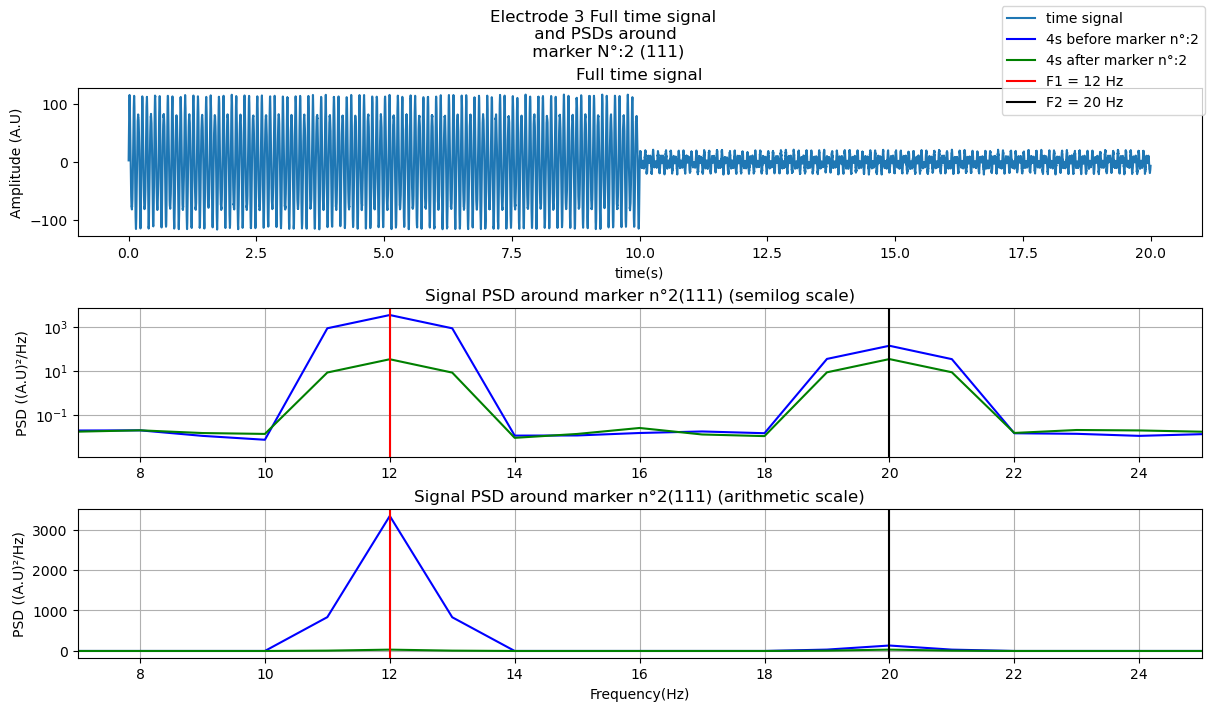

In [70]:
#Plot electrode i's time signal and PSDs around 1st marker 111
figure,axis=plt.subplots(3,1,num=6,figsize=(12, 7), layout="constrained")
figure.suptitle(f"Electrode {ELECTRODE_NUM} Full time signal \n and PSDs around \n "+
                f"marker N°:{MARKER_NUMBER} ({int(marker_timestamps[MARKER_INDEX][1])})")

#Whole time-signal subplot
axis[0].set_title("Full time signal")
axis[0].plot(times,signal_electrodes[:,SELECTOR],label="time signal") #pic dirac pour la PSD sur l'ensemble du signal
axis[0].set_ylabel("Amplitude (A.U)")
axis[0].set_xlabel("time(s)")

#PSD before marker
axis[1].set_title(f"Signal PSD around marker n°{MARKER_NUMBER}({int(marker_timestamps[MARKER_INDEX][1])}) (semilog scale)")
axis[1].semilogy(PSD_freqs,before_marker_n,"blue",label=str(TIME_WINDOW)+"s before marker n°:"+str(MARKER_NUMBER))
axis[1].semilogy(PSD_freqs,after_marker_n,"green",label=str(TIME_WINDOW)+"s after marker n°:"+str(MARKER_NUMBER))
axis[1].set_ylabel("PSD ((A.U)²/Hz)")
axis[1].set_xlim([min(signal_frequency1,signal_frequency2)-5,max(signal_frequency1,signal_frequency2)+5])

axis[1].axvline(x=signal_frequency1,color="red",label=f"F1 = {signal_frequency1} Hz")
axis[1].axvline(x=signal_frequency2,color="black",label=f"F2 = {signal_frequency2} Hz")

#PSD after marker
axis[2].set_title(f"Signal PSD around marker n°{MARKER_NUMBER}({int(marker_timestamps[MARKER_INDEX][1])}) (arithmetic scale)")
axis[2].plot(PSD_freqs,before_marker_n,"blue",label="_"+str(TIME_WINDOW)+"s before marker n°:"+str(MARKER_NUMBER))
axis[2].plot(PSD_freqs,after_marker_n,"green",label="_"+str(TIME_WINDOW)+"s after marker n°:"+str(MARKER_NUMBER))
axis[2].set_ylabel("PSD ((A.U)²/Hz)")
axis[2].set_xlabel("Frequency(Hz)")
axis[2].set_xlim([min(signal_frequency1,signal_frequency2)-5,max(signal_frequency1,signal_frequency2)+5])

#Frequencies defined for signal generation
axis[2].axvline(x=signal_frequency1,color="red",label=f"_F1 = {signal_frequency1} Hz")
axis[2].axvline(x=signal_frequency2,color="black",label=f"_F2 = {signal_frequency2} Hz")

axis[1].grid()
axis[2].grid() 
figure.legend(loc='upper right')
print(np.shape(PSD_freqs)) 

In [71]:
def give_results_summary(before_marker_n:np.array,after_marker_n:np.array):
    # What are the maximas of the power spectrum of the segments surrounding the 1st '111' marker?
    maxima_psd_before=np.max(before_marker_n) #1st marker 111 (2d marker of all)
    maxima_psd_after=np.max(after_marker_n) #1st marker 111 (2d marker of all)

    #Does the ratio of Psd maximas equals the ratio of time signal amplitudes?
    ratio_psd_maximas=maxima_psd_before/maxima_psd_after
    print(f"signal N°{ELECTRODE_NUM} - Marker N° {MARKER_NUMBER} ({int(marker_timestamps[MARKER_INDEX][1])}): Maxima of the PSD over {TIME_WINDOW} sec before Marker: {maxima_psd_before}")
    print(f"signal N°{ELECTRODE_NUM} - Marker N° {MARKER_NUMBER} ({int(marker_timestamps[MARKER_INDEX][1])}): Maxima of the PSD over {TIME_WINDOW} sec after Marker: {maxima_psd_after}")
    print(f"Ratio of the PSD maximas over {TIME_WINDOW}s on each side of the Marker 111: Rpsds(Before/After) = {ratio_psd_maximas}")

    #Can we see the amplitude switch on the power spectra? (cf original_amp_1 vs new_amp_1 )?
    try:
        ratio_signal_amplitude=eval("original_amp_"+str(ELECTRODE_NUM))/eval("new_amp_"+str(ELECTRODE_NUM))
        print(f"Ratio of the Amplitudes of the two sections of the signal: Ramplitudes(before/after) = {ratio_signal_amplitude}") 

    except: 
        print(f"Error: Chosen signal N°{ELECTRODE_NUM} is composed of more than 1 sine wave - Cannot compute the ratio of the amplitudes")
        #ratio_signal_amplitude=original_amp_1/new_amp_1
        #ratio_psd_maximas=maxima_psd_before/maxima_psd_after


In [72]:
#raw results (before rounding) 
give_results_summary(before_marker_n,after_marker_n)

signal N°3 - Marker N° 2 (111): Maxima of the PSD over 4 sec before Marker: 3335.230401801457
signal N°3 - Marker N° 2 (111): Maxima of the PSD over 4 sec after Marker: 33.434636956204606
Ratio of the PSD maximas over 4s on each side of the Marker 111: Rpsds(Before/After) = 99.75374956725899
Error: Chosen signal N°3 is composed of more than 1 sine wave - Cannot compute the ratio of the amplitudes


### Analysis 1<a   name="analysis1new"></a>

<u>Hyp1:</u> Since the energy carried out by a wave is proportional to the square of its amplitude, we expect that the ratio of energy between two sine wave is equal to the square of the ratio of their amplitude.
<br>Here integration time is the same so, ratio of power should be equal to the square of the amplitude ratio.


<u>Hyp2:</u> These maximas should be found at the signal frequency which is constant (ex: x=12Hz)

<u>CCL:</u> The result (cf above cell) <span style="background-color: green;">is coherent with this hypothesis</span>. We have indeed:
$$
\frac{PowerBefore}{PowerAfter}=(\frac{AmplitudeBefore}{AmplitudeAfter})²
$$

NB: We only change the amplitude of the signal at half duration, the frequency stays the same.


### Plot Signal i's ERSP around 1st marker 111<a   name="ERSPnew"></a>

In [73]:
# Rounding step to tackle imprecision in PSD results (on non-existing frequency components)
round_button=True
if round_button:
    after_marker_n=np.around(after_marker_n, decimals=0, out=None)
    before_marker_n=np.around(before_marker_n, decimals=0, out=None)
    after_marker_n=np.sqrt(after_marker_n)
    before_marker_n=np.sqrt(before_marker_n)

    #after_marker_n=np.fix(after_marker_n)
    #before_marker_n=np.fix(before_marker_n)

diff_PSDs=np.subtract(after_marker_n,before_marker_n)

#ERSP formula
#diff_PSDs=np.round(diff_PSDs,decimals=2)

ersp=np.divide(diff_PSDs,before_marker_n)*100 #returns nans if divided by 0
ersp=np.nan_to_num(ersp, copy=False, nan=0.0) #manage nan values

C:\Users\iWiss\AppData\Local\Temp\ipykernel_10888\307543272.py:17: RuntimeWarning: invalid value encountered in divide
  ersp=np.divide(diff_PSDs,before_marker_n)*100 #returns nans if divided by 0


In [74]:
#results after rounding
give_results_summary(before_marker_n,after_marker_n)

signal N°3 - Marker N° 2 (111): Maxima of the PSD over 4 sec before Marker: 57.74945887192364
signal N°3 - Marker N° 2 (111): Maxima of the PSD over 4 sec after Marker: 5.744562646538029
Ratio of the PSD maximas over 4s on each side of the Marker 111: Rpsds(Before/After) = 10.052890433134447
Error: Chosen signal N°3 is composed of more than 1 sine wave - Cannot compute the ratio of the amplitudes


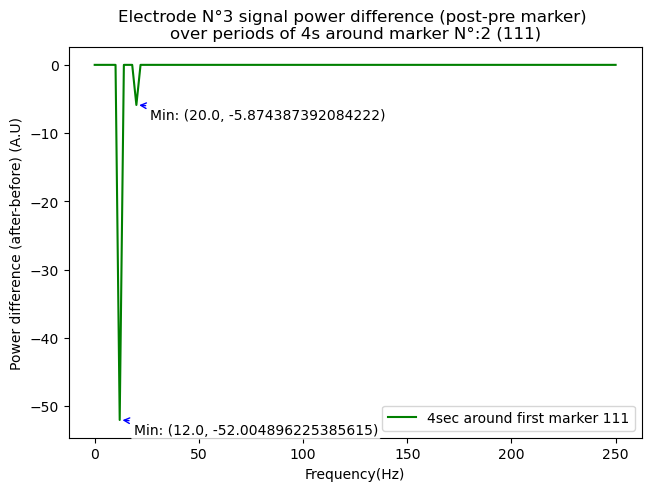

In [76]:
#Plot the difference between PSD after and before
figure,axis=plt.subplots(num=7,layout="constrained")
axis.plot(PSD_freqs,diff_PSDs,"-g",label="4sec around first marker 111") #pic dirac elargi a la base pour la PSD sur setion d'1sec du signal
#axis.axvline(12)

axis.set_title(f"Electrode N°{ELECTRODE_NUM} signal power difference (post-pre marker) \n"+
               f"over periods of {TIME_WINDOW}s around marker N°:{MARKER_NUMBER} ({int(marker_timestamps[MARKER_INDEX][1])})")

axis.set_ylabel("Power difference (after-before) (A.U)")
axis.set_xlabel("Frequency(Hz)")
annotate_local_extrema(x=PSD_freqs,y=diff_PSDs,axis=axis)
axis.legend()
#axis.set_xlim([min(signal_frequency1,signal_frequency2)-5,max(signal_frequency1,signal_frequency2)+5])

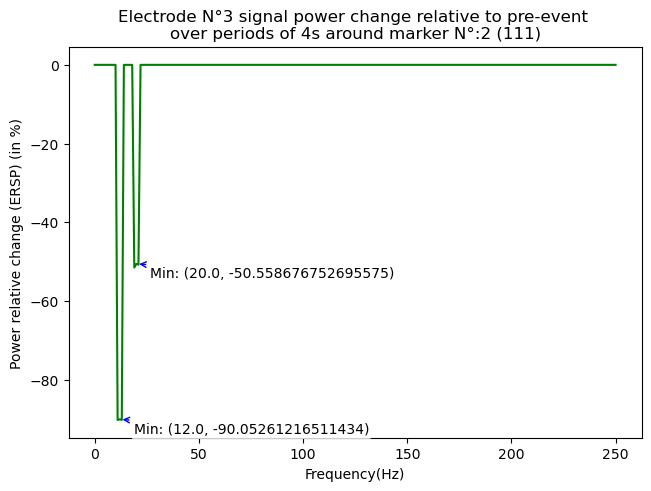

In [77]:
#Plot ERSP
figure,axis=plt.subplots(num=8,layout="constrained")
axis.plot(PSD_freqs,ersp,"-g",label="4sec around first marker 111") #pic dirac elargi a la base pour la PSD sur setion d'1sec du signal
axis.set_title(f"Electrode N°{ELECTRODE_NUM} signal power change relative to pre-event \n"+
               f"over periods of {TIME_WINDOW}s around marker N°:{MARKER_NUMBER} ({int(marker_timestamps[MARKER_INDEX][1])})")
axis.set_ylabel("Power relative change (ERSP) (in %)")
axis.set_xlabel("Frequency(Hz)")
annotate_local_extrema(x=PSD_freqs,y=ersp,axis=axis,order=1,window_size=3)
#axis.set_xlim([min(signal_frequency1,signal_frequency2)-5,max(signal_frequency1,signal_frequency2)+5])

### Analysis 2<a   name="analysis2new"></a>

Rappelons que le 1er marqueur 111 correspond uniquement au changement d'amplitude du signal. Et que le calcul des PSD est identique quel que soit le segment du signal sur lequel il est réalisé.
Ainsi en calculant la PSD sur un segment de taille identique (en nombre d'échantillons) avant et après le 1er marqueur 111, le seul paramètre changeant est l'amplitude de la sinusoïde.

On remarque dans le résultat des deux PSD qu'en plus d'avoir des valeurs de puissances autour de la fréquence du signal (spectral leakage ?) :
- Il existe des valeurs d'amplitude pour des fréquences qui en sont éloignées (pour f=12Hz, à 5Hz et 100Hz par exemple).
- On remarque aussi que ces puissances à des fréquences éloignées ne sont pas identiques. 

<u>CCL 1:</u> Alors qu'on s'attendait à des valeurs nulles à des fréquences éloignées, ce n'est pas le cas. <br><br>
<u>CCL 2:</u> Alors qu'on s'attendait à des valeurs identiques pour des fréquences non contenues dans le signal, ce n'est pas le cas.<br><br>
<u>CCL 3:</u> L'amplitude d'un signal de frequence unique impacte les valeurs de puissance même à des frequences non contenues dans celui ci.

Tout ceci fait que pour un signal de fréquence donné, même si les puissances avant et après le changement d'amplitude sont très proches, la formule de calcul des ERSP laisse au dénominateur des puissances négatives importantes. Cela se traduit en variations de puissance relative très élevées.

<u>CCL:</u> Le pb du calcul des ERSP semble donc résider dans le fait que la méthode de welch n'est pas parfaite.

<span style='color:red'> Quelle solution??</span >




<span style='background:green'> Solution:</span >
- Arrondir les valeurs d'amplitudes à l'unité près pour eviter de se retrouver lors du calcul de l'ERSP avec un numerateur proche de 0 et un dénominateur en puissances de 10 negatives. Cette methode cible donc les composantes frequentielles non existantes dans le signal avec un impact negligeable sur les frequences d'interet.
-Pour le moment employer la methode du zero-padding avec la methode de welch sur ces signaux pour chercher a augmenter la resolution frequentielle resulte en un phenomene de spectral leakage.
